In [1]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

from kaggle_datasets import KaggleDatasets
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import models
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras import layers, optimizers
from tensorflow.keras import models

from sklearn.model_selection import train_test_split
from functools import partial

# ignoring warnings
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')

2021-12-26 14:01:53.250079: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-26 14:01:53.250204: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf.keras.backend.clear_session()

XLA_ACCELERATE = True
MIXED_PRECISION = True

# Enabling XLA
if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
        
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    # Enabling mixed precision for TPUs
    if MIXED_PRECISION:
        #mixed_precision.set_global_policy('mixed_bfloat16')
        tf.keras.mixed_precision.set_global_policy("mixed_bfloat16")
        
except Exception as e:
    strategy = tf.distribute.get_strategy()

    # Enabling mixed precision for CPUs/GPUs
    if MIXED_PRECISION:
        #mixed_precision.set_global_policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy("mixed_bfloat16")

        
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.0.0.2:8470


2021-12-26 14:01:58.844735: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-26 14:01:58.848036: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-26 14:01:58.848075: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-26 14:01:58.848102: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c367684ccaa9): /proc/driver/nvidia/version does not exist
2021-12-26 14:01:58.848795: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [512, 512]
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [4]:
def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [5]:
database_base_path = '/kaggle/input/cassava-leaf-disease-classification/'
train = pd.read_csv(f'{database_base_path}train.csv')
print(f'Train samples: {len(train)}')

Train samples: 21397


In [7]:
GCS_PATH = KaggleDatasets().get_gcs_path('cassava-leaf-disease-classification')
filenames = tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/*.tfrec')
NUM_TRAINING_IMAGES = count_data_items(filenames)
print(f'GCS: train images: {NUM_TRAINING_IMAGES}')

GCS: train images: 21397


2021-12-26 14:08:10.486856: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [8]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset


TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec'),
    test_size=0.2, random_state=5
)

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test_tfrecords/ld_test*.tfrec')


def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=1) # rotate 90º
    image = tf.image.random_brightness(image, max_delta=.2)
    return image, label

2021-12-26 14:08:32.536112: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-12-26 14:08:32.682941: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Dataset: 16045 training images, 5352 validation images, 1 (unlabeled) test images


In [9]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)  
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)  
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [10]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

In [10]:
# Stop training when the validation loss metric has stopped decreasing for 5 epochs.
#early_stopping = EarlyStopping(monitor = 'val_loss',
#                              patience = 10,
#                               mode = 'min',
#                               restore_best_weights = True)

# Save the model with the minimum validation loss
#checkpoint = ModelCheckpoint('best_model.hdf5', 
#                             monitor = 'val_loss',
#                             verbose = 1,
#                             mode = 'min', 
#                             save_best_only = True)
# reduce learning rate
#reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
#                              factor = 0.2,
#                              patience = 3,
#                              min_lr = 0.001,
#                              mode = 'min',
#                              verbose = 1)

In [11]:
checkpoint = ModelCheckpoint('Tbest_model.hdf5', save_best_only = True, monitor = 'val_loss', mode = 'min', verbose = 1)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, mode = 'min', verbose = 1, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, min_delta = 0.001, mode = 'min', verbose = 1)

In [12]:
with strategy.scope():
    model = tf.keras.Sequential([
        efn.EfficientNetB7(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False
        ),
        layers.GlobalAveragePooling2D(),
        layers.Dense(5, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    
    model.summary()

258441216/258434480 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 12805     
Total params: 64,110,485
Trainable params: 63,799,765
Non-trainable params: 310,720
_________________________________________________________________


In [12]:
import tensorflow.keras.backend as K

def to_float32(image, label):
    return tf.cast(image, tf.float32), label

# TPUs need images in float format
train_dataset = get_training_dataset().map(to_float32)
valid_dataset = get_validation_dataset().map(to_float32)

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

In [14]:
history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=25,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS,
                    callbacks = [early_stopping, checkpoint, reduce_lr])

Epoch 1/25
125/125 [==============================] - 313s 954ms/step - loss: 0.7652 - sparse_categorical_accuracy: 0.7086 - val_loss: 0.6909 - val_sparse_categorical_accuracy: 0.8302

Epoch 00001: val_loss improved from inf to 0.69090, saving model to Tbest_model.hdf5
Epoch 2/25
125/125 [==============================] - 96s 771ms/step - loss: 0.4495 - sparse_categorical_accuracy: 0.8507 - val_loss: 0.6130 - val_sparse_categorical_accuracy: 0.8304

Epoch 00002: val_loss improved from 0.69090 to 0.61295, saving model to Tbest_model.hdf5
Epoch 3/25
125/125 [==============================] - 96s 770ms/step - loss: 0.4074 - sparse_categorical_accuracy: 0.8637 - val_loss: 0.4809 - val_sparse_categorical_accuracy: 0.8508

Epoch 00003: val_loss improved from 0.61295 to 0.48088, saving model to Tbest_model.hdf5
Epoch 4/25
125/125 [==============================] - 96s 769ms/step - loss: 0.3482 - sparse_categorical_accuracy: 0.8832 - val_loss: 0.4824 - val_sparse_categorical_accuracy: 0.8413



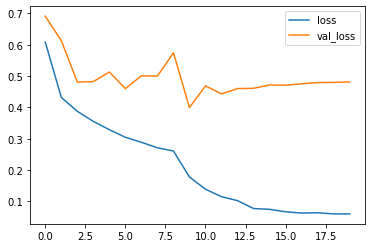

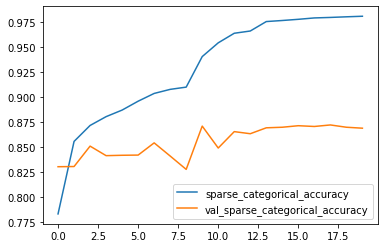

In [15]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

In [16]:
with strategy.scope():
    model = tf.keras.Sequential([
        efn.EfficientNetB7(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False
        ),
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation = 'relu'), 
        layers.Dropout(0.3),
        layers.Dense(5, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    
    model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1311232   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 65,411,477
Trainable params: 65,100,757
Non-trainable params: 310,720
_________________________________________________________________


In [17]:
history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=25,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS,
                    callbacks = [early_stopping, checkpoint, reduce_lr])

Epoch 1/25
125/125 [==============================] - 314s 921ms/step - loss: 0.8661 - sparse_categorical_accuracy: 0.6886 - val_loss: 0.8358 - val_sparse_categorical_accuracy: 0.8144

Epoch 00001: val_loss did not improve from 0.39968
Epoch 2/25
125/125 [==============================] - 96s 765ms/step - loss: 0.4621 - sparse_categorical_accuracy: 0.8452 - val_loss: 0.5135 - val_sparse_categorical_accuracy: 0.8340

Epoch 00002: val_loss did not improve from 0.39968
Epoch 3/25
125/125 [==============================] - 96s 767ms/step - loss: 0.4144 - sparse_categorical_accuracy: 0.8604 - val_loss: 0.5458 - val_sparse_categorical_accuracy: 0.8462

Epoch 00003: val_loss did not improve from 0.39968
Epoch 4/25
125/125 [==============================] - 96s 769ms/step - loss: 0.3760 - sparse_categorical_accuracy: 0.8762 - val_loss: 0.4174 - val_sparse_categorical_accuracy: 0.8641

Epoch 00004: val_loss did not improve from 0.39968
Epoch 5/25
125/125 [==============================] - 96s 7

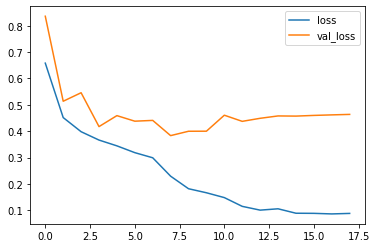

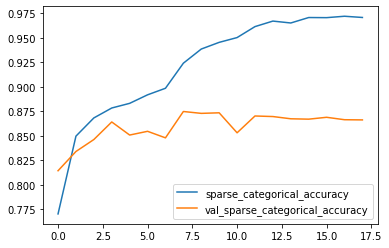

In [18]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

In [19]:
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.applications.Xception(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False
        ),
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation = 'relu'), 
        layers.Dropout(0.3),
        layers.Dense(5, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    
    model.summary()

83689472/83683744 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 2565      
Total params: 21,913,133
Trainable params: 21,858,605
Non-trainable params: 54,528
_________________________________________________________________


In [20]:
history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=25,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS,
                    callbacks = [early_stopping, checkpoint, reduce_lr])

Epoch 1/25
125/125 [==============================] - 108s 398ms/step - loss: 0.8166 - sparse_categorical_accuracy: 0.7188 - val_loss: 2.8388 - val_sparse_categorical_accuracy: 0.6700

Epoch 00001: val_loss did not improve from 0.38315
Epoch 2/25
125/125 [==============================] - 43s 342ms/step - loss: 0.4727 - sparse_categorical_accuracy: 0.8385 - val_loss: 0.7012 - val_sparse_categorical_accuracy: 0.7854

Epoch 00002: val_loss did not improve from 0.38315
Epoch 3/25
125/125 [==============================] - 42s 340ms/step - loss: 0.4241 - sparse_categorical_accuracy: 0.8609 - val_loss: 0.7048 - val_sparse_categorical_accuracy: 0.7578

Epoch 00003: val_loss did not improve from 0.38315
Epoch 4/25
125/125 [==============================] - 43s 342ms/step - loss: 0.3898 - sparse_categorical_accuracy: 0.8677 - val_loss: 0.5882 - val_sparse_categorical_accuracy: 0.8072

Epoch 00004: val_loss did not improve from 0.38315
Epoch 5/25
125/125 [==============================] - 43s 3

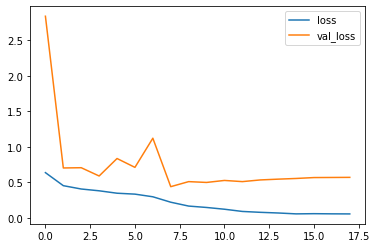

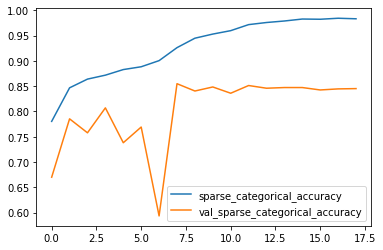

In [21]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

In [22]:
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.applications.Xception(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False
        ),
        layers.GlobalAveragePooling2D(),
        layers.Dense(5, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    
    model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 10245     
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


In [23]:
history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=25,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS,
                    callbacks = [early_stopping, checkpoint, reduce_lr])

Epoch 1/25
125/125 [==============================] - 96s 390ms/step - loss: 0.7037 - sparse_categorical_accuracy: 0.7410 - val_loss: 0.7312 - val_sparse_categorical_accuracy: 0.7856

Epoch 00001: val_loss did not improve from 0.38315
Epoch 2/25
125/125 [==============================] - 42s 338ms/step - loss: 0.4642 - sparse_categorical_accuracy: 0.8415 - val_loss: 1.2907 - val_sparse_categorical_accuracy: 0.4848

Epoch 00002: val_loss did not improve from 0.38315
Epoch 3/25
125/125 [==============================] - 42s 334ms/step - loss: 0.4019 - sparse_categorical_accuracy: 0.8642 - val_loss: 0.5132 - val_sparse_categorical_accuracy: 0.8384

Epoch 00003: val_loss did not improve from 0.38315
Epoch 4/25
125/125 [==============================] - 42s 340ms/step - loss: 0.3598 - sparse_categorical_accuracy: 0.8792 - val_loss: 0.7223 - val_sparse_categorical_accuracy: 0.7454

Epoch 00004: val_loss did not improve from 0.38315
Epoch 5/25
125/125 [==============================] - 42s 33

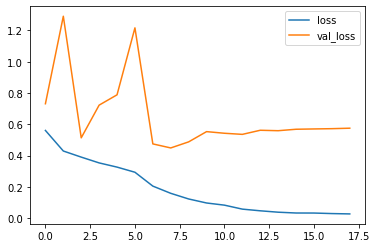

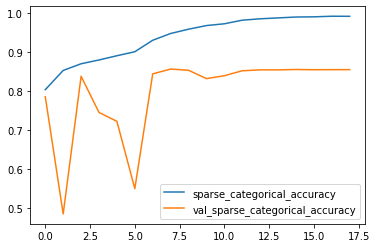

In [24]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

In [25]:
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.applications.ResNet50(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False
        ),
        layers.GlobalAveragePooling2D(),
        layers.Dense(5, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    
    model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


In [26]:
history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=25,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS,
                    callbacks = [early_stopping, checkpoint, reduce_lr])

Epoch 1/25
125/125 [==============================] - 99s 355ms/step - loss: 0.8926 - sparse_categorical_accuracy: 0.6837 - val_loss: 2.2113 - val_sparse_categorical_accuracy: 0.1252

Epoch 00001: val_loss did not improve from 0.38315
Epoch 2/25
125/125 [==============================] - 37s 295ms/step - loss: 0.5374 - sparse_categorical_accuracy: 0.8120 - val_loss: 1.6426 - val_sparse_categorical_accuracy: 0.1248

Epoch 00002: val_loss did not improve from 0.38315
Epoch 3/25
125/125 [==============================] - 36s 291ms/step - loss: 0.5063 - sparse_categorical_accuracy: 0.8317 - val_loss: 2.7112 - val_sparse_categorical_accuracy: 0.1252

Epoch 00003: val_loss did not improve from 0.38315
Epoch 4/25
125/125 [==============================] - 38s 303ms/step - loss: 0.4773 - sparse_categorical_accuracy: 0.8359 - val_loss: 1.9651 - val_sparse_categorical_accuracy: 0.1252

Epoch 00004: val_loss did not improve from 0.38315
Epoch 5/25
125/125 [==============================] - 37s 29

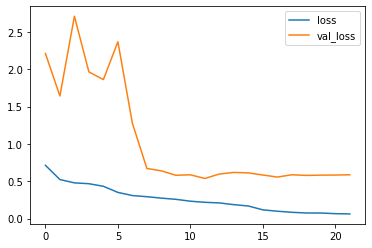

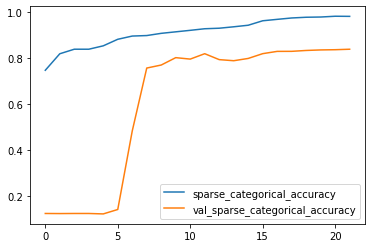

In [27]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

In [28]:
with strategy.scope():
    model = tf.keras.Sequential([
        efn.EfficientNetB4(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False
        ),
        layers.GlobalAveragePooling2D(),
        layers.Dense(5, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    
    model.summary()

71892992/71892840 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 16, 16, 1792)      17673816  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1792)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 8965      
Total params: 17,682,781
Trainable params: 17,557,581
Non-trainable params: 125,200
_________________________________________________________________


In [29]:
history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=25,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS,
                    callbacks = [early_stopping, checkpoint, reduce_lr])

Epoch 1/25
125/125 [==============================] - 184s 548ms/step - loss: 0.6919 - sparse_categorical_accuracy: 0.7454 - val_loss: 0.8453 - val_sparse_categorical_accuracy: 0.7119

Epoch 00001: val_loss did not improve from 0.38315
Epoch 2/25
125/125 [==============================] - 55s 439ms/step - loss: 0.4276 - sparse_categorical_accuracy: 0.8524 - val_loss: 0.4671 - val_sparse_categorical_accuracy: 0.8413

Epoch 00002: val_loss did not improve from 0.38315
Epoch 3/25
125/125 [==============================] - 55s 440ms/step - loss: 0.3554 - sparse_categorical_accuracy: 0.8759 - val_loss: 0.4620 - val_sparse_categorical_accuracy: 0.8510

Epoch 00003: val_loss did not improve from 0.38315
Epoch 4/25
125/125 [==============================] - 55s 440ms/step - loss: 0.3348 - sparse_categorical_accuracy: 0.8845 - val_loss: 0.4981 - val_sparse_categorical_accuracy: 0.8356

Epoch 00004: val_loss did not improve from 0.38315
Epoch 5/25
125/125 [==============================] - 55s 4

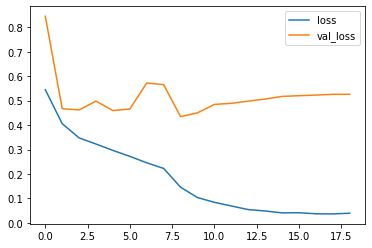

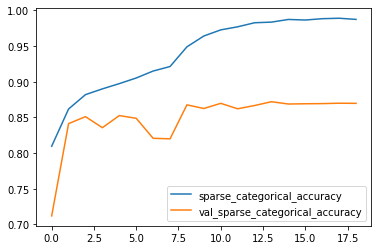

In [30]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

In [31]:
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.applications.VGG16(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False
        ),
        layers.GlobalAveragePooling2D(),
        layers.Dense(5, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    
    model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 16, 16, 512)       14714688  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 14,717,253
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=50,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS,
                    callbacks = [early_stopping, checkpoint, reduce_lr])

Epoch 1/50
125/125 [==============================] - 76s 452ms/step - loss: 67.1149 - sparse_categorical_accuracy: 0.5407 - val_loss: 1.1675 - val_sparse_categorical_accuracy: 0.6084

Epoch 00001: val_loss did not improve from 0.38315
Epoch 2/50
125/125 [==============================] - 51s 409ms/step - loss: 1.1529 - sparse_categorical_accuracy: 0.6167 - val_loss: 1.2725 - val_sparse_categorical_accuracy: 0.5970

Epoch 00002: val_loss did not improve from 0.38315
Epoch 3/50
125/125 [==============================] - 52s 412ms/step - loss: 1.1135 - sparse_categorical_accuracy: 0.6195 - val_loss: 1.1103 - val_sparse_categorical_accuracy: 0.6134

Epoch 00003: val_loss did not improve from 0.38315
Epoch 4/50
125/125 [==============================] - 51s 412ms/step - loss: 1.1223 - sparse_categorical_accuracy: 0.6105 - val_loss: 1.1916 - val_sparse_categorical_accuracy: 0.6119

Epoch 00004: val_loss did not improve from 0.38315
Epoch 5/50
125/125 [==============================] - 52s 4

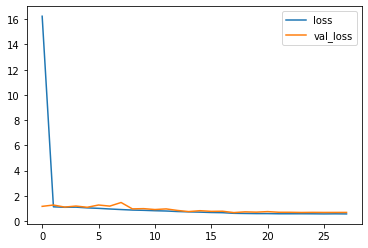

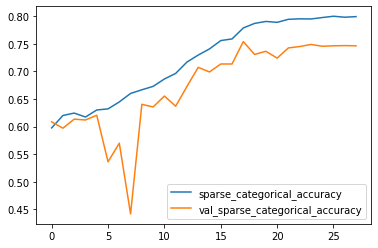

In [33]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

In [34]:
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.applications.VGG19(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False
        ),
        layers.GlobalAveragePooling2D(),
        layers.Dense(5, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    
    model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 16, 16, 512)       20024384  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 2565      
Total params: 20,026,949
Trainable params: 20,026,949
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=50,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS,
                    callbacks = [early_stopping, checkpoint, reduce_lr])

Epoch 1/50
125/125 [==============================] - 85s 496ms/step - loss: 24.7707 - sparse_categorical_accuracy: 0.5314 - val_loss: 1.1787 - val_sparse_categorical_accuracy: 0.6084

Epoch 00001: val_loss did not improve from 0.38315
Epoch 2/50
125/125 [==============================] - 56s 450ms/step - loss: 1.1798 - sparse_categorical_accuracy: 0.6109 - val_loss: 1.1293 - val_sparse_categorical_accuracy: 0.6084

Epoch 00002: val_loss did not improve from 0.38315
Epoch 3/50
125/125 [==============================] - 56s 451ms/step - loss: 1.1136 - sparse_categorical_accuracy: 0.6133 - val_loss: 1.1426 - val_sparse_categorical_accuracy: 0.5968

Epoch 00003: val_loss did not improve from 0.38315
Epoch 4/50
125/125 [==============================] - 57s 456ms/step - loss: 1.0527 - sparse_categorical_accuracy: 0.6243 - val_loss: 1.0720 - val_sparse_categorical_accuracy: 0.6271

Epoch 00004: val_loss did not improve from 0.38315
Epoch 5/50
125/125 [==============================] - 56s 4

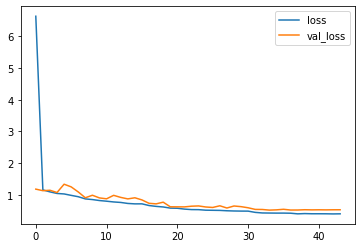

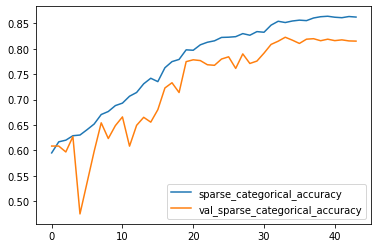

In [36]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

In [16]:
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.applications.NASNetLarge(
            input_shape=(*IMAGE_SIZE, 3),
            weights=None,
            include_top=False
        ),
        layers.GlobalAveragePooling2D(),
        layers.Dense(5, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    
    model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 16, 16, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 4032)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 20165     
Total params: 84,936,983
Trainable params: 84,740,315
Non-trainable params: 196,668
_________________________________________________________________


In [17]:
history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=25,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS,
                    callbacks = [early_stopping, checkpoint, reduce_lr])

Epoch 1/25
125/125 [==============================] - 439s 1s/step - loss: 1.5056 - sparse_categorical_accuracy: 0.5821 - val_loss: 1420.5487 - val_sparse_categorical_accuracy: 0.1023

Epoch 00001: val_loss did not improve from 13.45446
Epoch 2/25
125/125 [==============================] - 112s 891ms/step - loss: 1.0437 - sparse_categorical_accuracy: 0.6246 - val_loss: 593.7744 - val_sparse_categorical_accuracy: 0.0467

Epoch 00002: val_loss did not improve from 13.45446
Epoch 3/25
125/125 [==============================] - 112s 894ms/step - loss: 0.9531 - sparse_categorical_accuracy: 0.6426 - val_loss: 336.8155 - val_sparse_categorical_accuracy: 0.1877

Epoch 00003: val_loss did not improve from 13.45446
Epoch 4/25
125/125 [==============================] - 111s 890ms/step - loss: 0.8940 - sparse_categorical_accuracy: 0.6583 - val_loss: 3976.3169 - val_sparse_categorical_accuracy: 0.5844

Epoch 00004: val_loss did not improve from 13.45446
Epoch 5/25
125/125 [=========================

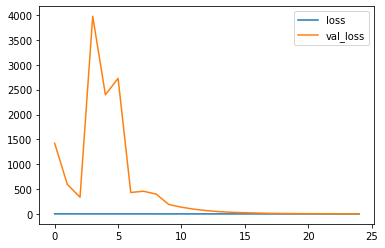

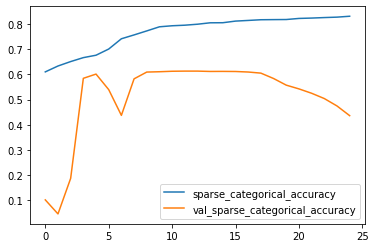

In [18]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();